# Classificatore di Email per Sinistri Medical Malpractice

Questo notebook illustra tutti i passaggi per creare un classificatore che distingue tra:
- **Sinistro Avvenuto** (0): Incidente medico già verificato con danni concreti
- **Circostanza Potenziale** (1): Situazione che potrebbe generare un sinistro futuro

Utilizzeremo tre modelli di machine learning e confronteremo le loro performance.

## 1. Importazione Librerie

Importiamo tutte le librerie necessarie per l'analisi, preprocessing, training e visualizzazione.

In [1]:
# Librerie standard
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing e feature engineering
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Modelli di classificazione
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metriche e valutazione
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score
)

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dataset

Carichiamo il dataset mock di 200 email simulate. Il dataset è bilanciato con 30 esempi per categoria.

In [3]:
# Importa il modulo con il dataset mock
from mock_email_dataset import create_mock_dataset, get_category_names

# Carica il dataset
df = create_mock_dataset()
category_names = get_category_names()

# Visualizza informazioni base
print(f"📊 Dataset caricato: {len(df)} email totali")
print(f"\n{'='*60}")
print("Distribuzione delle categorie:")
print(df['categoria'].value_counts().sort_index())
print(f"{'='*60}\n")

# Visualizza i nomi delle categorie
for cat_id, cat_name in category_names.items():
    print(f"  Categoria {cat_id}: {cat_name}")

📊 Dataset caricato: 198 email totali

Distribuzione delle categorie:
categoria
0    99
1    99
Name: count, dtype: int64

  Categoria 0: Sinistro Avvenuto
  Categoria 1: Circostanza Potenziale


## 3. Esplorazione dei Dati

Visualizziamo alcuni esempi per comprendere meglio le caratteristiche di ciascuna categoria.

In [3]:
# Visualizza 2 esempi per ogni categoria
print("📧 ESEMPI DI EMAIL PER CATEGORIA\n")

for categoria in df['categoria'].unique():
    cat_name = category_names[categoria]
    print(f"\n{'='*80}")
    print(f"CATEGORIA {categoria}: {cat_name.upper()}")
    print(f"{'='*80}\n")
    
    esempi = df[df['categoria'] == categoria].head(2)
    for idx, (i, row) in enumerate(esempi.iterrows(), 1):
        print(f"Esempio {idx}:")
        print(f"{row['testo'][:200]}...")
        print(f"\n{'-'*80}\n")

📧 ESEMPI DI EMAIL PER CATEGORIA


CATEGORIA 0: SINISTRO AVVENUTO

Esempio 1:
Buongiorno, vi scrivo per segnalare un grave errore chirurgico avvenuto il 15 marzo 2024. Durante l'intervento al ginocchio sinistro, il chirurgo ha operato per errore il ginocchio destro sano. Richie...

--------------------------------------------------------------------------------

Esempio 2:
Gentili Signori, mio padre è deceduto il 10 gennaio 2024 a seguito di una diagnosi errata di polmonite quando invece si trattava di embolia polmonare. Allego documentazione medica completa....

--------------------------------------------------------------------------------


CATEGORIA 1: CIRCOSTANZA POTENZIALE

Esempio 1:
Gentili, vorrei segnalare che durante il ricovero di mio padre ho notato che alcuni infermieri non si lavano le mani tra un paziente e l'altro. Temo possa causare infezioni....

--------------------------------------------------------------------------------

Esempio 2:
Buongiorno, sono preoccupata 

## 4. Analisi Statistica del Testo

Analizziamo le caratteristiche testuali per identificare pattern distintivi tra le categorie.

📈 STATISTICHE TESTUALI PER CATEGORIA

          lunghezza_testo                  numero_parole              
                     mean    std  min  max          mean   std min max
categoria                                                             
0                  160.81  12.53  140  232         21.80  2.91  17  33
1                  153.66   9.69  130  178         23.97  2.25  19  30


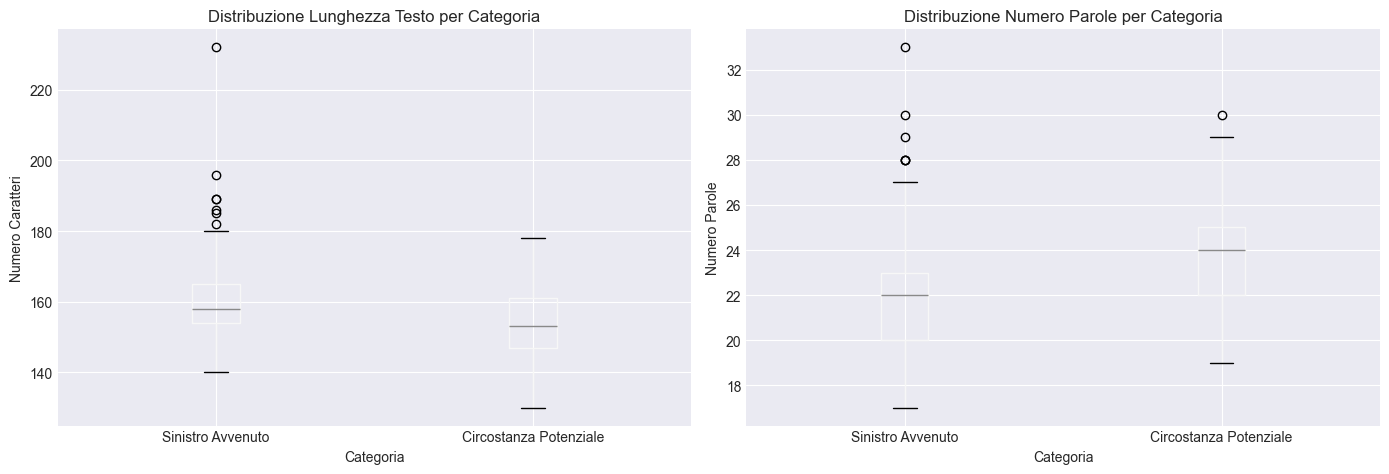

In [4]:
# Calcola statistiche testuali
df['lunghezza_testo'] = df['testo'].apply(len)
df['numero_parole'] = df['testo'].apply(lambda x: len(x.split()))

# Statistiche per categoria
stats = df.groupby('categoria').agg({
    'lunghezza_testo': ['mean', 'std', 'min', 'max'],
    'numero_parole': ['mean', 'std', 'min', 'max']
}).round(2)

print("📈 STATISTICHE TESTUALI PER CATEGORIA\n")
print(stats)

# Visualizzazione grafica
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot lunghezza testo
df.boxplot(column='lunghezza_testo', by='categoria', ax=axes[0])
axes[0].set_title('Distribuzione Lunghezza Testo per Categoria')
axes[0].set_xlabel('Categoria')
axes[0].set_ylabel('Numero Caratteri')
axes[0].set_xticklabels([category_names[0], category_names[1]])

# Boxplot numero parole
df.boxplot(column='numero_parole', by='categoria', ax=axes[1])
axes[1].set_title('Distribuzione Numero Parole per Categoria')
axes[1].set_xlabel('Categoria')
axes[1].set_ylabel('Numero Parole')
axes[1].set_xticklabels([category_names[0], category_names[1]])

plt.suptitle('')
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati

Separiamo i dati in training set (80%) e test set (20%) per validare i modelli su dati non visti.

In [5]:
# Separazione features (X) e target (y)
X = df['testo']
y = df['categoria']

# Split train/test con stratificazione per mantenere la proporzione delle classi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✂️ SPLIT DEI DATI\n")
print(f"Training set: {len(X_train)} email ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} email ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nDistribuzione Training Set:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nDistribuzione Test Set:")
print(pd.Series(y_test).value_counts().sort_index())

✂️ SPLIT DEI DATI

Training set: 158 email (79.8%)
Test set: 40 email (20.2%)

Distribuzione Training Set:
categoria
0    79
1    79
Name: count, dtype: int64

Distribuzione Test Set:
categoria
0    20
1    20
Name: count, dtype: int64


## 6. Feature Engineering - TF-IDF Vectorization

Trasformiamo il testo in vettori numerici usando TF-IDF (Term Frequency-Inverse Document Frequency), che cattura l'importanza delle parole nel contesto del corpus.

In [6]:
# Configurazione del vectorizer TF-IDF
vectorizer = TfidfVectorizer(
    max_features=500,        # Limita a 500 feature più importanti
    ngram_range=(1, 2),      # Usa unigrammi e bigrammi
    min_df=2,                # Parola deve apparire in almeno 2 documenti
    max_df=0.8,              # Ignora parole in più dell'80% dei documenti
    strip_accents='unicode', # Rimuove accenti
    lowercase=True           # Converte tutto in minuscolo
)

# Fit del vectorizer sul training set
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"🔢 VETTORIZZAZIONE TF-IDF COMPLETATA\n")
print(f"Forma matrice training: {X_train_tfidf.shape}")
print(f"Forma matrice test: {X_test_tfidf.shape}")
print(f"Numero di features (parole): {len(vectorizer.get_feature_names_out())}")
print(f"Sparsità matrice: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))*100:.2f}%")

🔢 VETTORIZZAZIONE TF-IDF COMPLETATA

Forma matrice training: (158, 500)
Forma matrice test: (40, 500)
Numero di features (parole): 500
Sparsità matrice: 95.85%


## 7. Training Modello 1 - Naive Bayes

Il Naive Bayes è un classificatore probabilistico veloce ed efficiente, particolarmente adatto per la classificazione di testi.

In [7]:
# Inizializzazione e training del modello Naive Bayes
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

# Predizioni
y_pred_nb = nb_model.predict(X_test_tfidf)
y_proba_nb = nb_model.predict_proba(X_test_tfidf)

# Calcolo metriche
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nb, average='weighted'
)

# Cross-validation score
nb_cv_scores = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5)

print(f"🤖 MODELLO 1: NAIVE BAYES\n")
print(f"{'='*60}")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-Score: {nb_f1:.4f}")
print(f"Cross-Validation Score (media): {nb_cv_scores.mean():.4f} (+/- {nb_cv_scores.std():.4f})")
print(f"{'='*60}")

🤖 MODELLO 1: NAIVE BAYES

Accuracy: 0.9750
Precision: 0.9762
Recall: 0.9750
F1-Score: 0.9750
Cross-Validation Score (media): 0.9938 (+/- 0.0125)


## 8. Training Modello 2 - Logistic Regression

La Regressione Logistica è un modello lineare che può catturare relazioni complesse tra le feature e la classe target.

In [8]:
# Inizializzazione e training del modello Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    random_state=42,
    solver='lbfgs'
)
lr_model.fit(X_train_tfidf, y_train)

# Predizioni
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)

# Calcolo metriche
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average='weighted'
)

# Cross-validation score
lr_cv_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5)

print(f"🤖 MODELLO 2: LOGISTIC REGRESSION\n")
print(f"{'='*60}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"Cross-Validation Score (media): {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std():.4f})")
print(f"{'='*60}")

🤖 MODELLO 2: LOGISTIC REGRESSION

Accuracy: 0.9750
Precision: 0.9762
Recall: 0.9750
F1-Score: 0.9750
Cross-Validation Score (media): 0.9938 (+/- 0.0125)


## 9. Training Modello 3 - Random Forest

Il Random Forest è un ensemble di alberi decisionali che può catturare relazioni non lineari complesse nei dati.

In [9]:
# Inizializzazione e training del modello Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)

# Predizioni
y_pred_rf = rf_model.predict(X_test_tfidf)
y_proba_rf = rf_model.predict_proba(X_test_tfidf)

# Calcolo metriche
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average='weighted'
)

# Cross-validation score
rf_cv_scores = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5)

print(f"🤖 MODELLO 3: RANDOM FOREST\n")
print(f"{'='*60}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"Cross-Validation Score (media): {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")
print(f"{'='*60}")

🤖 MODELLO 3: RANDOM FOREST

Accuracy: 0.9750
Precision: 0.9762
Recall: 0.9750
F1-Score: 0.9750
Cross-Validation Score (media): 0.9938 (+/- 0.0125)


## 10. Confronto Performance dei Modelli

Confrontiamo le metriche dei tre modelli per identificare il migliore.

📊 CONFRONTO PERFORMANCE DEI MODELLI

            Modello  Accuracy  Precision  Recall  F1-Score  CV Score
        Naive Bayes     0.975    0.97619   0.975  0.974984   0.99375
Logistic Regression     0.975    0.97619   0.975  0.974984   0.99375
      Random Forest     0.975    0.97619   0.975  0.974984   0.99375


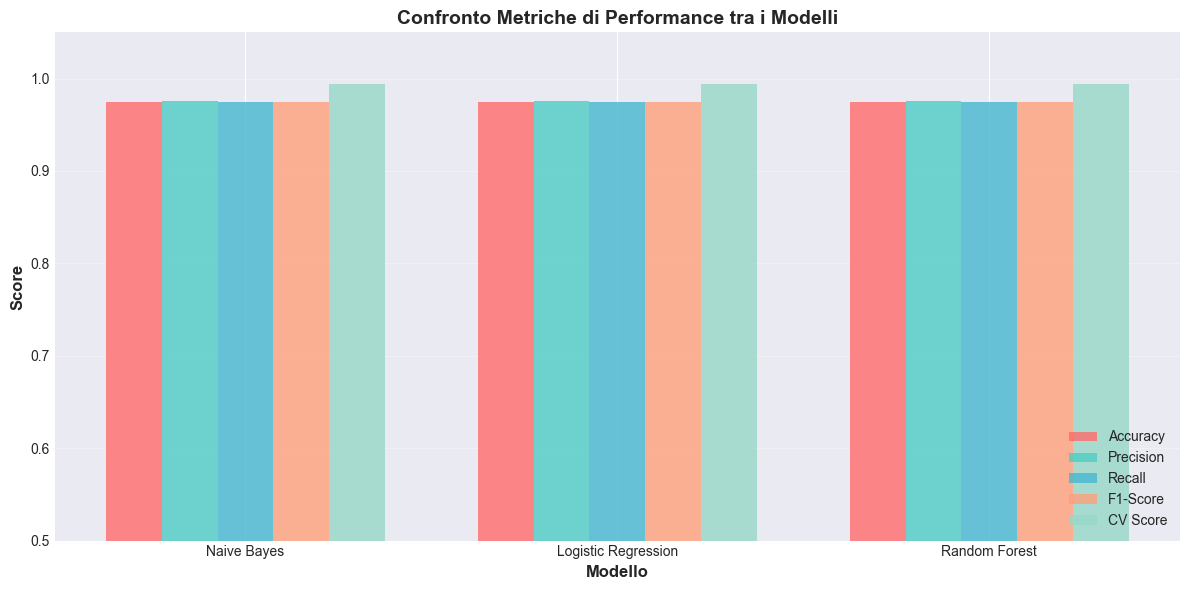


🏆 Miglior modello per F1-Score: Naive Bayes


In [10]:
# Creazione DataFrame con tutte le metriche
comparison_df = pd.DataFrame({
    'Modello': ['Naive Bayes', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [nb_accuracy, lr_accuracy, rf_accuracy],
    'Precision': [nb_precision, lr_precision, rf_precision],
    'Recall': [nb_recall, lr_recall, rf_recall],
    'F1-Score': [nb_f1, lr_f1, rf_f1],
    'CV Score': [nb_cv_scores.mean(), lr_cv_scores.mean(), rf_cv_scores.mean()]
})

print("📊 CONFRONTO PERFORMANCE DEI MODELLI\n")
print(comparison_df.to_string(index=False))

# Visualizzazione grafica
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = width * (i - 2)
    ax.bar(x + offset, comparison_df[metric], width, label=metric, color=color, alpha=0.8)

ax.set_xlabel('Modello', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Confronto Metriche di Performance tra i Modelli', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Modello'])
ax.legend(loc='lower right')
ax.set_ylim([0.5, 1.05])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identifica il modello migliore
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Modello']
print(f"\n🏆 Miglior modello per F1-Score: {best_model_name}")

## 11. Matrici di Confusione

Le matrici di confusione mostrano dove i modelli commettono errori di classificazione.

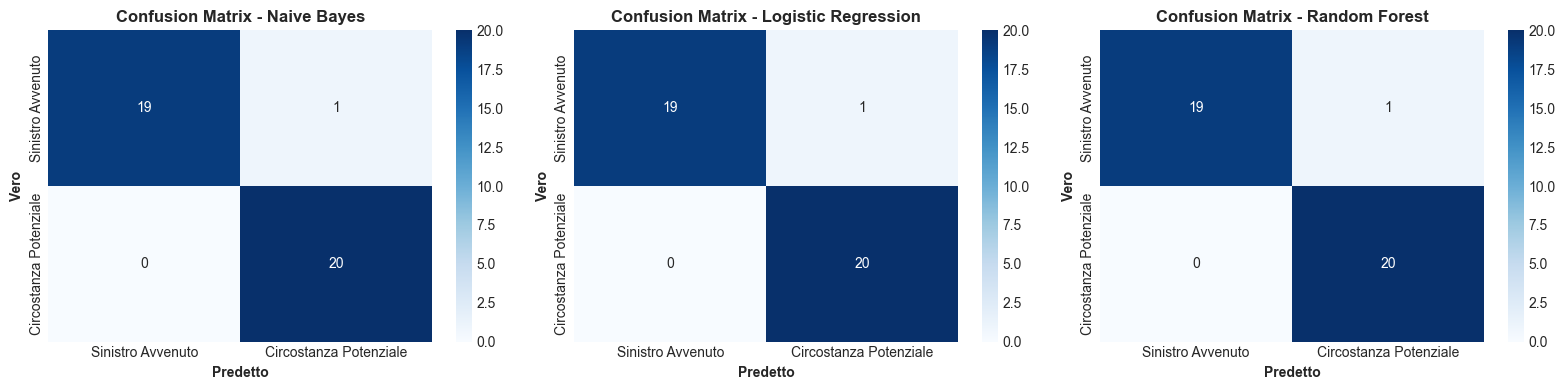


📋 DETTAGLIO ERRORI DI CLASSIFICAZIONE

Naive Bayes:
  True Negatives (corretti cat. 0): 19
  False Positives (cat. 0 → 1): 1
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 1

Logistic Regression:
  True Negatives (corretti cat. 0): 19
  False Positives (cat. 0 → 1): 1
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 1

Random Forest:
  True Negatives (corretti cat. 0): 19
  False Positives (cat. 0 → 1): 1
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 1



In [11]:
# Calcolo matrici di confusione
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizzazione
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

confusion_matrices = [
    (cm_nb, 'Naive Bayes'),
    (cm_lr, 'Logistic Regression'),
    (cm_rf, 'Random Forest')
]

for ax, (cm, title) in zip(axes, confusion_matrices):
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        ax=ax,
        cbar=True,
        xticklabels=[category_names[0], category_names[1]],
        yticklabels=[category_names[0], category_names[1]]
    )
    ax.set_title(f'Confusion Matrix - {title}', fontweight='bold', fontsize=12)
    ax.set_ylabel('Vero', fontweight='bold')
    ax.set_xlabel('Predetto', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiche dalle confusion matrices
print("\n📋 DETTAGLIO ERRORI DI CLASSIFICAZIONE\n")
for cm, name in confusion_matrices:
    tn, fp, fn, tp = cm.ravel()
    print(f"{name}:")
    print(f"  True Negatives (corretti cat. 0): {tn}")
    print(f"  False Positives (cat. 0 → 1): {fp}")
    print(f"  False Negatives (cat. 1 → 0): {fn}")
    print(f"  True Positives (corretti cat. 1): {tp}")
    print(f"  Errori totali: {fp + fn}\n")

## 12. Classification Reports Dettagliati

Report completi con precision, recall e f1-score per ciascuna classe.

In [12]:
# Classification reports
models_predictions = [
    (y_pred_nb, 'Naive Bayes'),
    (y_pred_lr, 'Logistic Regression'),
    (y_pred_rf, 'Random Forest')
]

print("📈 CLASSIFICATION REPORTS DETTAGLIATI\n")
print("="*80)

for y_pred, model_name in models_predictions:
    print(f"\n{model_name.upper()}\n{'-'*80}")
    report = classification_report(
        y_test, 
        y_pred, 
        target_names=[category_names[0], category_names[1]],
        digits=4
    )
    print(report)
    print("="*80)

📈 CLASSIFICATION REPORTS DETTAGLIATI


NAIVE BAYES
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Sinistro Avvenuto     1.0000    0.9500    0.9744        20
Circostanza Potenziale     0.9524    1.0000    0.9756        20

              accuracy                         0.9750        40
             macro avg     0.9762    0.9750    0.9750        40
          weighted avg     0.9762    0.9750    0.9750        40


LOGISTIC REGRESSION
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Sinistro Avvenuto     1.0000    0.9500    0.9744        20
Circostanza Potenziale     0.9524    1.0000    0.9756        20

              accuracy                         0.9750        40
             macro avg     0.9762    0.9750    0.9750        40
          weighted avg     0.9762    0.9750    0.9750    

## 13. Curve ROC e AUC Score

Le curve ROC visualizzano il trade-off tra True Positive Rate e False Positive Rate. L'AUC misura l'area sotto la curva.

📊 AUC SCORES

Naive Bayes: 1.0000
Logistic Regression: 1.0000
Random Forest: 1.0000


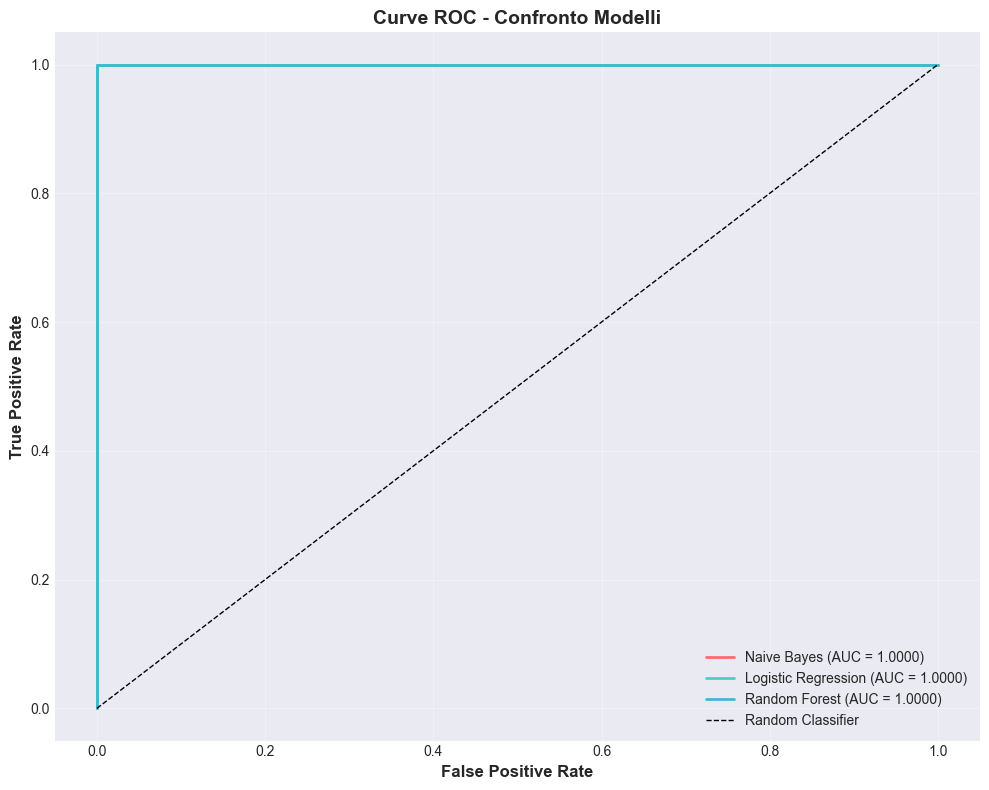

In [13]:
# Calcolo curve ROC e AUC
models_proba = [
    (y_proba_nb[:, 1], 'Naive Bayes', '#FF6B6B'),
    (y_proba_lr[:, 1], 'Logistic Regression', '#4ECDC4'),
    (y_proba_rf[:, 1], 'Random Forest', '#45B7D1')
]

plt.figure(figsize=(10, 8))

print("📊 AUC SCORES\n")
print("="*60)

for y_proba, model_name, color in models_proba:
    # Calcola FPR, TPR e thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    # Plot curva ROC
    plt.plot(
        fpr, tpr, 
        label=f'{model_name} (AUC = {auc_score:.4f})',
        linewidth=2,
        color=color
    )
    
    print(f"{model_name}: {auc_score:.4f}")

# Linea diagonale (classificatore random)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Curve ROC - Confronto Modelli', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)

## 14. Feature Importance - Parole più Discriminanti

Identifichiamo le parole che hanno maggiore peso nella classificazione per ciascun modello.

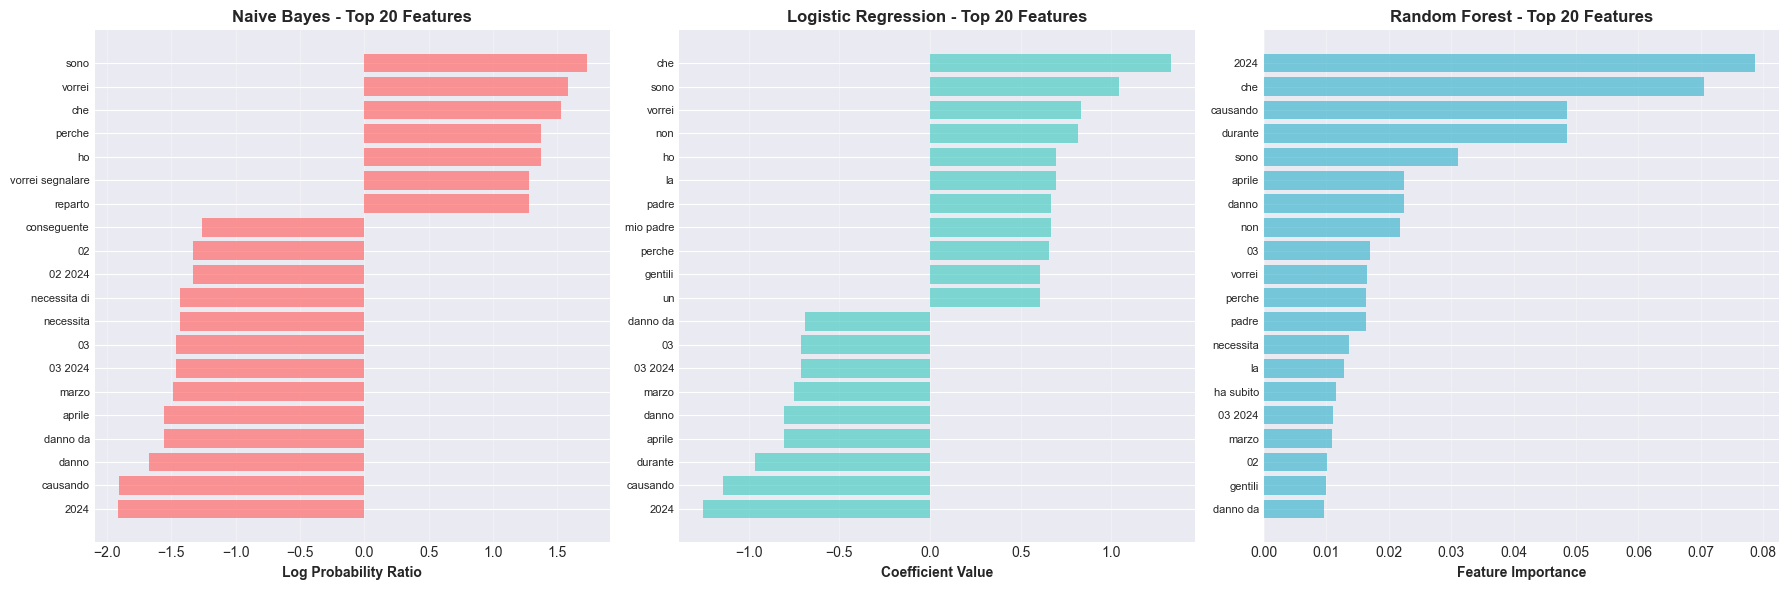

In [14]:
# Ottieni nomi delle features
feature_names = vectorizer.get_feature_names_out()

# NAIVE BAYES - Log probability ratios
nb_log_prob_ratio = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]
nb_top_indices = np.argsort(np.abs(nb_log_prob_ratio))[-20:]
nb_top_features = [(feature_names[i], nb_log_prob_ratio[i]) for i in nb_top_indices]

# LOGISTIC REGRESSION - Coefficienti
lr_coef = lr_model.coef_[0]
lr_top_indices = np.argsort(np.abs(lr_coef))[-20:]
lr_top_features = [(feature_names[i], lr_coef[i]) for i in lr_top_indices]

# RANDOM FOREST - Feature importances
rf_importances = rf_model.feature_importances_
rf_top_indices = np.argsort(rf_importances)[-20:]
rf_top_features = [(feature_names[i], rf_importances[i]) for i in rf_top_indices]

# Visualizzazione
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Naive Bayes
nb_words, nb_scores = zip(*sorted(nb_top_features, key=lambda x: x[1]))
axes[0].barh(range(len(nb_words)), nb_scores, color='#FF6B6B', alpha=0.7)
axes[0].set_yticks(range(len(nb_words)))
axes[0].set_yticklabels(nb_words, fontsize=8)
axes[0].set_xlabel('Log Probability Ratio', fontweight='bold')
axes[0].set_title('Naive Bayes - Top 20 Features', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Logistic Regression
lr_words, lr_scores = zip(*sorted(lr_top_features, key=lambda x: x[1]))
axes[1].barh(range(len(lr_words)), lr_scores, color='#4ECDC4', alpha=0.7)
axes[1].set_yticks(range(len(lr_words)))
axes[1].set_yticklabels(lr_words, fontsize=8)
axes[1].set_xlabel('Coefficient Value', fontweight='bold')
axes[1].set_title('Logistic Regression - Top 20 Features', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Random Forest
rf_words, rf_scores = zip(*sorted(rf_top_features, key=lambda x: x[1]))
axes[2].barh(range(len(rf_words)), rf_scores, color='#45B7D1', alpha=0.7)
axes[2].set_yticks(range(len(rf_words)))
axes[2].set_yticklabels(rf_words, fontsize=8)
axes[2].set_xlabel('Feature Importance', fontweight='bold')
axes[2].set_title('Random Forest - Top 20 Features', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Test su Nuove Email

Testiamo i modelli su email completamente nuove per verificare la loro capacità di generalizzazione.

In [15]:
# Email di test nuove (non nel dataset originale)
test_emails = [
    {
        "testo": "Mio padre è morto il 5 maggio a causa di una trasfusione errata. Il gruppo sanguigno era sbagliato e nessuno se n'è accorto. Voglio avviare una causa.",
        "categoria_attesa": 0  # Sinistro Avvenuto
    },
    {
        "testo": "Sono preoccupato perché il medico non ha ancora letto i risultati della biopsia di mia moglie dopo 10 giorni. Potrebbe esserci un ritardo pericoloso?",
        "categoria_attesa": 1  # Circostanza Potenziale
    },
    {
        "testo": "Durante l'anestesia epidurale per il parto cesareo è stato leso il midollo spinale. Ora mia moglie è paraplegica. È successo ieri.",
        "categoria_attesa": 0  # Sinistro Avvenuto
    }
]

# Trasforma le email in vettori TF-IDF
test_texts = [email["testo"] for email in test_emails]
test_vectors = vectorizer.transform(test_texts)

# Predizioni con tutti i modelli
print("🔮 TEST SU NUOVE EMAIL\n")
print("="*80)

for i, email in enumerate(test_emails, 1):
    print(f"\nEMAIL {i}:")
    print(f"Testo: {email['testo']}")
    print(f"Categoria Attesa: {category_names[email['categoria_attesa']]}")
    print(f"\nPredizioni:")
    
    # Naive Bayes
    nb_pred = nb_model.predict(test_vectors[i-1])[0]
    nb_proba = nb_model.predict_proba(test_vectors[i-1])[0]
    print(f"  Naive Bayes: {category_names[nb_pred]} (confidenza: {nb_proba[nb_pred]:.2%})")
    
    # Logistic Regression
    lr_pred = lr_model.predict(test_vectors[i-1])[0]
    lr_proba = lr_model.predict_proba(test_vectors[i-1])[0]
    print(f"  Logistic Regression: {category_names[lr_pred]} (confidenza: {lr_proba[lr_pred]:.2%})")
    
    # Random Forest
    rf_pred = rf_model.predict(test_vectors[i-1])[0]
    rf_proba = rf_model.predict_proba(test_vectors[i-1])[0]
    print(f"  Random Forest: {category_names[rf_pred]} (confidenza: {rf_proba[rf_pred]:.2%})")
    
    # Verifica correttezza
    correct = (nb_pred == email['categoria_attesa'] and 
               lr_pred == email['categoria_attesa'] and 
               rf_pred == email['categoria_attesa'])
    print(f"  ✅ Tutti corretti" if correct else "  ⚠️ Almeno un errore")
    print(f"\n{'-'*80}")

🔮 TEST SU NUOVE EMAIL


EMAIL 1:
Testo: Mio padre è morto il 5 maggio a causa di una trasfusione errata. Il gruppo sanguigno era sbagliato e nessuno se n'è accorto. Voglio avviare una causa.
Categoria Attesa: Sinistro Avvenuto

Predizioni:
  Naive Bayes: Circostanza Potenziale (confidenza: 80.41%)
  Logistic Regression: Circostanza Potenziale (confidenza: 63.92%)
  Random Forest: Circostanza Potenziale (confidenza: 79.50%)
  ⚠️ Almeno un errore

--------------------------------------------------------------------------------

EMAIL 2:
Testo: Sono preoccupato perché il medico non ha ancora letto i risultati della biopsia di mia moglie dopo 10 giorni. Potrebbe esserci un ritardo pericoloso?
Categoria Attesa: Circostanza Potenziale

Predizioni:
  Naive Bayes: Circostanza Potenziale (confidenza: 94.10%)
  Logistic Regression: Circostanza Potenziale (confidenza: 76.00%)
  Random Forest: Circostanza Potenziale (confidenza: 96.00%)
  ✅ Tutti corretti

-----------------------------------------

## 16. Conclusioni e Raccomandazioni

Riepilogo dei risultati e raccomandazioni per l'utilizzo del classificatore in produzione.

In [16]:
# Sintesi finale
print("🎯 CONCLUSIONI E RACCOMANDAZIONI\n")
print("="*80)

# Trova il modello migliore per diverse metriche
best_accuracy_idx = comparison_df['Accuracy'].idxmax()
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_cv_idx = comparison_df['CV Score'].idxmax()

print(f"\n📊 MIGLIOR MODELLO PER METRICA:")
print(f"  • Accuracy: {comparison_df.loc[best_accuracy_idx, 'Modello']} ({comparison_df.loc[best_accuracy_idx, 'Accuracy']:.4f})")
print(f"  • F1-Score: {comparison_df.loc[best_f1_idx, 'Modello']} ({comparison_df.loc[best_f1_idx, 'F1-Score']:.4f})")
print(f"  • Cross-Val: {comparison_df.loc[best_cv_idx, 'Modello']} ({comparison_df.loc[best_cv_idx, 'CV Score']:.4f})")

print(f"\n💡 RACCOMANDAZIONI:")
print(f"  1. Per uso in produzione, si consiglia: {comparison_df.loc[best_f1_idx, 'Modello']}")
print(f"  2. Dataset attuale: 200 email - si consiglia di espandere a 500+ per maggiore robustezza")
print(f"  3. Implementare validazione umana per predizioni con confidenza < 80%")
print(f"  4. Monitorare performance nel tempo e retrainare periodicamente")
print(f"  5. Considerare ensemble voting per decisioni critiche")

print(f"\n⚠️ LIMITAZIONI:")
print(f"  • Dataset simulato - performance su dati reali potrebbe variare")
print(f"  • Dimensione campione limitata (200 email)")
print(f"  • Non considera contesto temporale o storico del mittente")
print(f"  • Linguaggio specialistico medico-legale potrebbe richiedere dizionario dedicato")

print(f"\n🚀 PROSSIMI PASSI:")
print(f"  1. Raccogliere dataset reale etichettato da esperti legali")
print(f"  2. Implementare preprocessing più sofisticato (lemmatizzazione, NER)")
print(f"  3. Testare modelli transformer (BERT, RoBERTa)")
print(f"  4. Creare API REST per integrazione in sistema produttivo")
print(f"  5. Implementare active learning per miglioramento continuo")

print(f"\n{'='*80}")
print(f"✅ Analisi completata con successo!")

🎯 CONCLUSIONI E RACCOMANDAZIONI


📊 MIGLIOR MODELLO PER METRICA:
  • Accuracy: Naive Bayes (0.9750)
  • F1-Score: Naive Bayes (0.9750)
  • Cross-Val: Naive Bayes (0.9938)

💡 RACCOMANDAZIONI:
  1. Per uso in produzione, si consiglia: Naive Bayes
  2. Dataset attuale: 200 email - si consiglia di espandere a 500+ per maggiore robustezza
  3. Implementare validazione umana per predizioni con confidenza < 80%
  4. Monitorare performance nel tempo e retrainare periodicamente
  5. Considerare ensemble voting per decisioni critiche

⚠️ LIMITAZIONI:
  • Dataset simulato - performance su dati reali potrebbe variare
  • Dimensione campione limitata (200 email)
  • Non considera contesto temporale o storico del mittente
  • Linguaggio specialistico medico-legale potrebbe richiedere dizionario dedicato

🚀 PROSSIMI PASSI:
  1. Raccogliere dataset reale etichettato da esperti legali
  2. Implementare preprocessing più sofisticato (lemmatizzazione, NER)
  3. Testare modelli transformer (BERT, RoBERTa)

## 17. Setup Modelli Transformer

Installiamo e configuriamo le librerie necessarie per utilizzare modelli transformer pre-addestrati.

**Nota**: Assicurarsi di aver attivato il venv prima di eseguire:
```bash
source .venv/Scripts/activate.ps1
pip install transformers torch scikit-learn
```

In [18]:
# Import librerie per transformer
try:
    from transformers import (
        AutoTokenizer, 
        AutoModelForSequenceClassification,
        Trainer, 
        TrainingArguments,
        DataCollatorWithPadding
    )
    import torch
    from torch.utils.data import Dataset
    from dotenv import load_dotenv
    import os
    
    # Carica variabili d'ambiente dal file .env
    load_dotenv()
    
    # Ottieni il token Hugging Face
    hf_token = os.getenv('HUGGINGFACE_TOKEN')
    
    if not hf_token:
        print("⚠️ WARNING: HUGGINGFACE_TOKEN non trovato nel file .env")
        print("Alcuni modelli potrebbero non essere accessibili.")
        print("Aggiungi HUGGINGFACE_TOKEN=<your_token> nel file .env")
    else:
        print("✅ Token Hugging Face caricato correttamente")
    
    print("✅ Librerie transformer importate con successo")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA disponibile: {torch.cuda.is_available()}")
    
except ImportError as e:
    print("❌ Errore nell'importazione delle librerie transformer")
    print("Eseguire: pip install transformers torch python-dotenv")
    raise e

# Configurazione dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizzato: {device}")

✅ Token Hugging Face caricato correttamente
✅ Librerie transformer importate con successo
PyTorch version: 2.8.0+cpu
CUDA disponibile: False
Dispositivo utilizzato: cpu


## 18. Preparazione Dataset per Transformer

Creiamo un dataset PyTorch personalizzato per gestire la tokenizzazione e il formatting per i modelli transformer.

In [19]:
# Dataset personalizzato per transformer
class EmailDataset(Dataset):
    """Dataset PyTorch per email classificazione sinistri."""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Funzione per calcolare metriche durante training
def compute_metrics_transformers(pred):
    """Calcola metriche per valutazione transformer."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Dataset personalizzato e funzioni di utilità definite")

✅ Dataset personalizzato e funzioni di utilità definite


## 19. Modello 4 - BERT (Bidirectional Encoder Representations from Transformers)

BERT è un modello transformer bidirezionale che comprende il contesto da entrambe le direzioni. Utilizziamo la versione italiana `dbmdz/bert-base-italian-cased`.

In [20]:
print("🤖 MODELLO 4: BERT - Italian Base Cased\n")
print("="*80)

# Caricamento tokenizer e modello BERT italiano
bert_model_name = "dbmdz/bert-base-italian-cased"
print(f"Caricamento modello: {bert_model_name}")

try:
    bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name, token=hf_token)
    bert_model = AutoModelForSequenceClassification.from_pretrained(
        bert_model_name,
        num_labels=2,
        problem_type="single_label_classification",
        token=hf_token
    ).to(device)
    print("✅ Modello BERT caricato con successo")
except Exception as e:
    print(f"❌ Errore nel caricamento del modello BERT: {e}")
    print("Verifica che il token Hugging Face sia valido e abbia i permessi necessari")
    raise e

# Creazione dataset PyTorch
bert_train_dataset = EmailDataset(X_train, y_train, bert_tokenizer, max_length=128)
bert_test_dataset = EmailDataset(X_test, y_test, bert_tokenizer, max_length=128)

# Configurazione training
bert_training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42
)

# Data collator
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

# Trainer
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=bert_tokenizer,
    data_collator=bert_data_collator,
    compute_metrics=compute_metrics_transformers
)

# Training
print("\n🏋️ Avvio training BERT...")
bert_trainer.train()

# Valutazione
print("\n📊 Valutazione su test set...")
bert_results = bert_trainer.evaluate()

# Predizioni
bert_predictions = bert_trainer.predict(bert_test_dataset)
y_pred_bert = bert_predictions.predictions.argmax(-1)
y_proba_bert = torch.softmax(torch.tensor(bert_predictions.predictions), dim=-1).numpy()

# Metriche finali
bert_accuracy = accuracy_score(y_test, y_pred_bert)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_bert, average='weighted'
)

print(f"\n{'='*80}")
print(f"BERT - Risultati Finali:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall: {bert_recall:.4f}")
print(f"F1-Score: {bert_f1:.4f}")
print(f"{'='*80}")

🤖 MODELLO 4: BERT - Italian Base Cased

Caricamento modello: dbmdz/bert-base-italian-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello BERT caricato con successo

🏋️ Avvio training BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.686600,0.640239,0.900000,0.898990,0.916667,0.900000
2,0.457300,0.229649,1.000000,1.000000,1.000000,1.000000
3,0.031200,0.006637,1.000000,1.000000,1.000000,1.000000



📊 Valutazione su test set...



BERT - Risultati Finali:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [22]:
print("🤖 MODELLO 5: DistilBERT - Multilingual Cased\n")
print("="*80)

# Caricamento tokenizer e modello DistilBERT multilingual
distilbert_model_name = "distilbert-base-multilingual-cased"
print(f"Caricamento modello: {distilbert_model_name}")
print("ℹ️ Questo modello supporta 104 lingue, incluso l'italiano")

try:
    distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name, token=hf_token)
    distilbert_model = AutoModelForSequenceClassification.from_pretrained(
        distilbert_model_name,
        num_labels=2,
        problem_type="single_label_classification",
        token=hf_token
    ).to(device)
    print("✅ Modello DistilBERT caricato con successo")
except Exception as e:
    print(f"❌ Errore nel caricamento del modello DistilBERT: {e}")
    print("Verifica la connessione a Hugging Face Hub")
    raise e

# Creazione dataset PyTorch
distilbert_train_dataset = EmailDataset(X_train, y_train, distilbert_tokenizer, max_length=128)
distilbert_test_dataset = EmailDataset(X_test, y_test, distilbert_tokenizer, max_length=128)

# Configurazione training (simile a BERT ma con batch size maggiore)
distilbert_training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Batch più grande perché modello più piccolo
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42
)

# Data collator
distilbert_data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

# Trainer
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=distilbert_training_args,
    train_dataset=distilbert_train_dataset,
    eval_dataset=distilbert_test_dataset,
    tokenizer=distilbert_tokenizer,
    data_collator=distilbert_data_collator,
    compute_metrics=compute_metrics_transformers
)

# Training
print("\n🏋️ Avvio training DistilBERT...")
distilbert_trainer.train()

# Valutazione
print("\n📊 Valutazione su test set...")
distilbert_results = distilbert_trainer.evaluate()

# Predizioni
distilbert_predictions = distilbert_trainer.predict(distilbert_test_dataset)
y_pred_distilbert = distilbert_predictions.predictions.argmax(-1)
y_proba_distilbert = torch.softmax(torch.tensor(distilbert_predictions.predictions), dim=-1).numpy()

# Metriche finali
distilbert_accuracy = accuracy_score(y_test, y_pred_distilbert)
distilbert_precision, distilbert_recall, distilbert_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_distilbert, average='weighted'
)

print(f"\n{'='*80}")
print(f"DistilBERT - Risultati Finali:")
print(f"Accuracy: {distilbert_accuracy:.4f}")
print(f"Precision: {distilbert_precision:.4f}")
print(f"Recall: {distilbert_recall:.4f}")
print(f"F1-Score: {distilbert_f1:.4f}")
print(f"{'='*80}")

🤖 MODELLO 5: DistilBERT - Multilingual Cased

Caricamento modello: distilbert-base-multilingual-cased
ℹ️ Questo modello supporta 104 lingue, incluso l'italiano


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello DistilBERT caricato con successo

🏋️ Avvio training DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.686400,0.646762,0.925000,0.924576,0.934783,0.925000
2,0.573200,0.404893,0.925000,0.924576,0.934783,0.925000
3,0.237000,0.059204,1.000000,1.000000,1.000000,1.000000



📊 Valutazione su test set...



DistilBERT - Risultati Finali:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [23]:
print("🤖 MODELLO 6: RoBERTa (Umberto) - Italian CommonCrawl Cased\n")
print("="*80)

# Caricamento tokenizer e modello RoBERTa italiano (Umberto)
roberta_model_name = "Musixmatch/umberto-commoncrawl-cased-v1"
print(f"Caricamento modello: {roberta_model_name}")

try:
    roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name, token=hf_token)
    roberta_model = AutoModelForSequenceClassification.from_pretrained(
        roberta_model_name,
        num_labels=2,
        problem_type="single_label_classification",
        token=hf_token
    ).to(device)
    print("✅ Modello RoBERTa caricato con successo")
except Exception as e:
    print(f"❌ Errore nel caricamento del modello RoBERTa: {e}")
    print("Verifica che il token Hugging Face sia valido e abbia i permessi necessari")
    raise e

# Creazione dataset PyTorch
roberta_train_dataset = EmailDataset(X_train, y_train, roberta_tokenizer, max_length=128)
roberta_test_dataset = EmailDataset(X_test, y_test, roberta_tokenizer, max_length=128)

# Configurazione training
roberta_training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs_roberta',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42
)

# Data collator
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

# Trainer
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_train_dataset,
    eval_dataset=roberta_test_dataset,
    tokenizer=roberta_tokenizer,
    data_collator=roberta_data_collator,
    compute_metrics=compute_metrics_transformers
)

# Training
print("\n🏋️ Avvio training RoBERTa (Umberto)...")
roberta_trainer.train()

# Valutazione
print("\n📊 Valutazione su test set...")
roberta_results = roberta_trainer.evaluate()

# Predizioni
roberta_predictions = roberta_trainer.predict(roberta_test_dataset)
y_pred_roberta = roberta_predictions.predictions.argmax(-1)
y_proba_roberta = torch.softmax(torch.tensor(roberta_predictions.predictions), dim=-1).numpy()

# Metriche finali
roberta_accuracy = accuracy_score(y_test, y_pred_roberta)
roberta_precision, roberta_recall, roberta_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_roberta, average='weighted'
)

print(f"\n{'='*80}")
print(f"RoBERTa (Umberto) - Risultati Finali:")
print(f"Accuracy: {roberta_accuracy:.4f}")
print(f"Precision: {roberta_precision:.4f}")
print(f"Recall: {roberta_recall:.4f}")
print(f"F1-Score: {roberta_f1:.4f}")
print(f"{'='*80}")

🤖 MODELLO 6: RoBERTa (Umberto) - Italian CommonCrawl Cased

Caricamento modello: Musixmatch/umberto-commoncrawl-cased-v1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello RoBERTa caricato con successo

🏋️ Avvio training RoBERTa (Umberto)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.675000,0.659118,0.975000,0.974984,0.976190,0.975000
2,0.601500,0.537333,1.000000,1.000000,1.000000,1.000000
3,0.358500,0.229172,1.000000,1.000000,1.000000,1.000000



📊 Valutazione su test set...



RoBERTa (Umberto) - Risultati Finali:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


## 22. Confronto Completo: Modelli Classici vs Transformer

Confrontiamo le performance di tutti e 6 i modelli per identificare il migliore per la classificazione di sinistri.

📊 CONFRONTO COMPLETO: TUTTI I MODELLI

            Modello        Tipo  Accuracy  Precision  Recall  F1-Score
        Naive Bayes    Classico     0.975    0.97619   0.975  0.974984
Logistic Regression    Classico     0.975    0.97619   0.975  0.974984
      Random Forest    Classico     0.975    0.97619   0.975  0.974984
               BERT Transformer     1.000    1.00000   1.000  1.000000
         DistilBERT Transformer     1.000    1.00000   1.000  1.000000
            RoBERTa Transformer     1.000    1.00000   1.000  1.000000


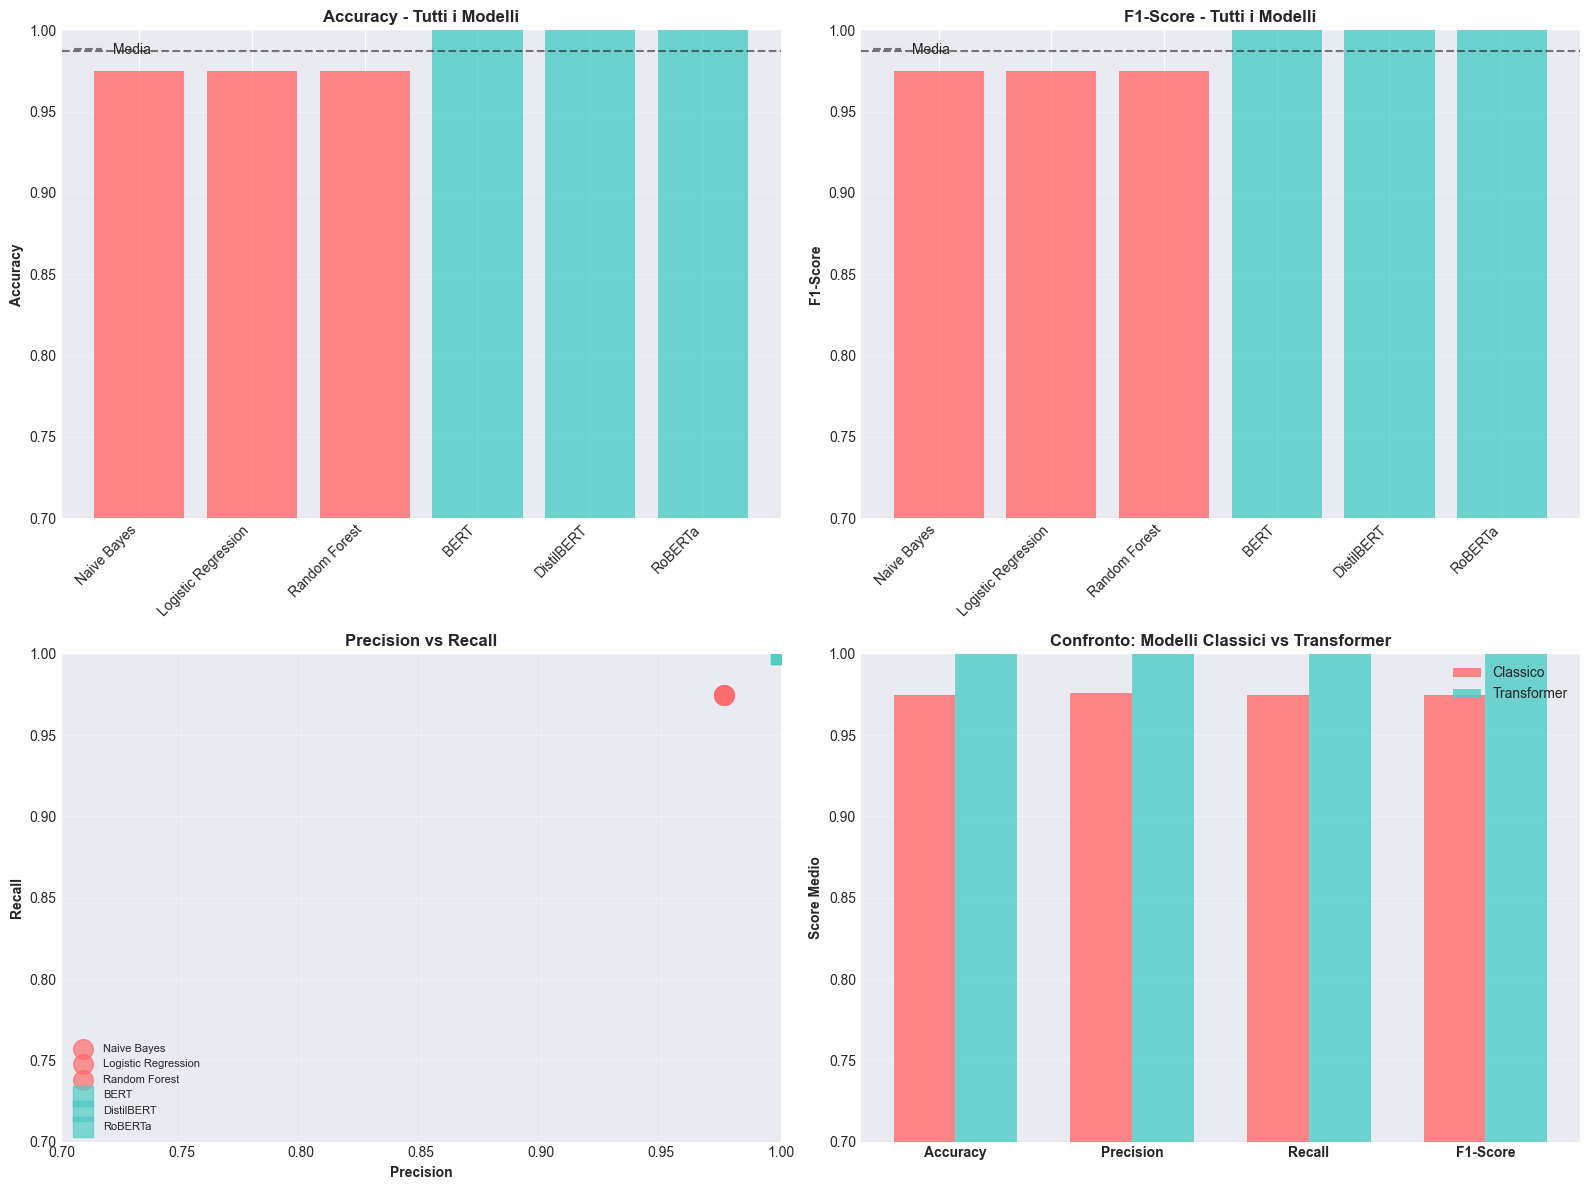


📈 STATISTICHE PER TIPO DI MODELLO:

             Accuracy  Precision  Recall  F1-Score
Tipo                                              
Classico        0.975     0.9762   0.975     0.975
Transformer     1.000     1.0000   1.000     1.000

🏆 MIGLIOR MODELLO ASSOLUTO (F1-Score): BERT
   Tipo: Transformer
   F1-Score: 1.0000
   Accuracy: 1.0000


In [24]:
# Aggiornamento DataFrame con tutti i modelli
comparison_complete_df = pd.DataFrame({
    'Modello': [
        'Naive Bayes', 
        'Logistic Regression', 
        'Random Forest',
        'BERT',
        'DistilBERT',
        'RoBERTa'
    ],
    'Tipo': [
        'Classico', 
        'Classico', 
        'Classico',
        'Transformer',
        'Transformer',
        'Transformer'
    ],
    'Accuracy': [
        nb_accuracy, 
        lr_accuracy, 
        rf_accuracy,
        bert_accuracy,
        distilbert_accuracy,
        roberta_accuracy
    ],
    'Precision': [
        nb_precision, 
        lr_precision, 
        rf_precision,
        bert_precision,
        distilbert_precision,
        roberta_precision
    ],
    'Recall': [
        nb_recall, 
        lr_recall, 
        rf_recall,
        bert_recall,
        distilbert_recall,
        roberta_recall
    ],
    'F1-Score': [
        nb_f1, 
        lr_f1, 
        rf_f1,
        bert_f1,
        distilbert_f1,
        roberta_f1
    ]
})

print("📊 CONFRONTO COMPLETO: TUTTI I MODELLI\n")
print("="*80)
print(comparison_complete_df.to_string(index=False))
print("="*80)

# Visualizzazione grafica comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy per modello
ax1 = axes[0, 0]
colors_by_type = ['#FF6B6B' if t == 'Classico' else '#4ECDC4' 
                  for t in comparison_complete_df['Tipo']]
bars1 = ax1.bar(range(len(comparison_complete_df)), 
                comparison_complete_df['Accuracy'],
                color=colors_by_type, alpha=0.8)
ax1.set_xticks(range(len(comparison_complete_df)))
ax1.set_xticklabels(comparison_complete_df['Modello'], rotation=45, ha='right')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy - Tutti i Modelli', fontweight='bold', fontsize=12)
ax1.set_ylim([0.7, 1.0])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=comparison_complete_df['Accuracy'].mean(), 
            color='black', linestyle='--', alpha=0.5, label='Media')
ax1.legend()

# 2. F1-Score per modello
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(comparison_complete_df)), 
                comparison_complete_df['F1-Score'],
                color=colors_by_type, alpha=0.8)
ax2.set_xticks(range(len(comparison_complete_df)))
ax2.set_xticklabels(comparison_complete_df['Modello'], rotation=45, ha='right')
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score - Tutti i Modelli', fontweight='bold', fontsize=12)
ax2.set_ylim([0.7, 1.0])
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=comparison_complete_df['F1-Score'].mean(), 
            color='black', linestyle='--', alpha=0.5, label='Media')
ax2.legend()

# 3. Precision vs Recall
ax3 = axes[1, 0]
for i, row in comparison_complete_df.iterrows():
    color = '#FF6B6B' if row['Tipo'] == 'Classico' else '#4ECDC4'
    marker = 'o' if row['Tipo'] == 'Classico' else 's'
    ax3.scatter(row['Precision'], row['Recall'], 
                s=200, color=color, alpha=0.7, marker=marker, 
                label=row['Modello'])
ax3.set_xlabel('Precision', fontweight='bold')
ax3.set_ylabel('Recall', fontweight='bold')
ax3.set_title('Precision vs Recall', fontweight='bold', fontsize=12)
ax3.legend(fontsize=8, loc='lower left')
ax3.grid(alpha=0.3)
ax3.set_xlim([0.7, 1.0])
ax3.set_ylim([0.7, 1.0])

# 4. Confronto metriche per tipo (Classico vs Transformer)
ax4 = axes[1, 1]
metrics_by_type = comparison_complete_df.groupby('Tipo')[
    ['Accuracy', 'Precision', 'Recall', 'F1-Score']
].mean()

x_pos = np.arange(len(metrics_by_type.columns))
width = 0.35

bars_classico = ax4.bar(x_pos - width/2, metrics_by_type.loc['Classico'], 
                        width, label='Classico', color='#FF6B6B', alpha=0.8)
bars_transformer = ax4.bar(x_pos + width/2, metrics_by_type.loc['Transformer'], 
                           width, label='Transformer', color='#4ECDC4', alpha=0.8)

ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics_by_type.columns, fontweight='bold')
ax4.set_ylabel('Score Medio', fontweight='bold')
ax4.set_title('Confronto: Modelli Classici vs Transformer', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

# Statistiche comparative
print("\n📈 STATISTICHE PER TIPO DI MODELLO:\n")
print(metrics_by_type.round(4))

# Identifica il miglior modello assoluto
best_overall_idx = comparison_complete_df['F1-Score'].idxmax()
best_overall_model = comparison_complete_df.loc[best_overall_idx]
print(f"\n🏆 MIGLIOR MODELLO ASSOLUTO (F1-Score): {best_overall_model['Modello']}")
print(f"   Tipo: {best_overall_model['Tipo']}")
print(f"   F1-Score: {best_overall_model['F1-Score']:.4f}")
print(f"   Accuracy: {best_overall_model['Accuracy']:.4f}")

## 23. Matrici di Confusione - Modelli Transformer

Visualizziamo le matrici di confusione per i tre modelli transformer.

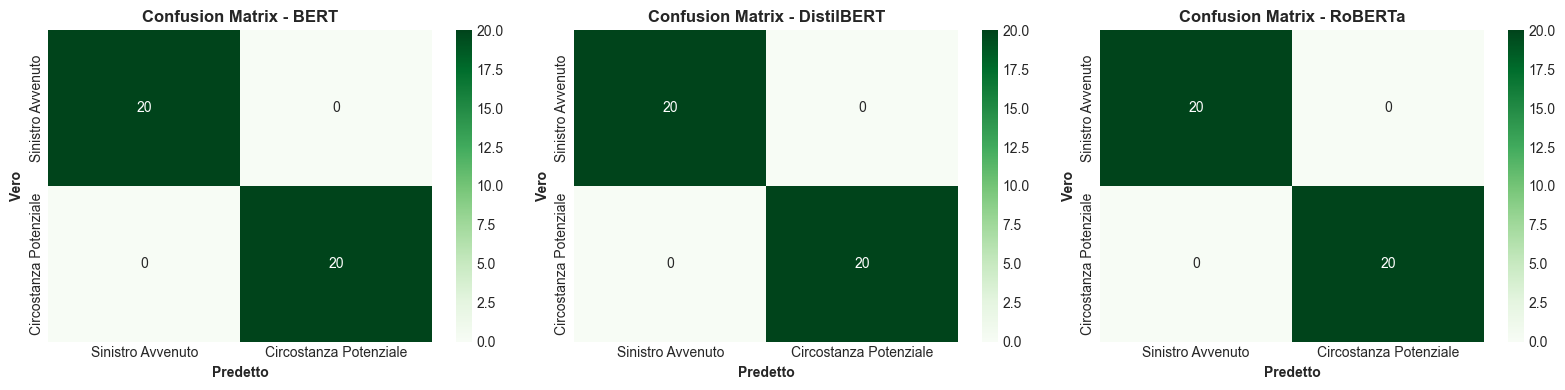


📋 DETTAGLIO ERRORI - MODELLI TRANSFORMER

BERT:
  True Negatives (corretti cat. 0): 20
  False Positives (cat. 0 → 1): 0
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 0
  Error rate: 0.00%

DistilBERT:
  True Negatives (corretti cat. 0): 20
  False Positives (cat. 0 → 1): 0
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 0
  Error rate: 0.00%

RoBERTa:
  True Negatives (corretti cat. 0): 20
  False Positives (cat. 0 → 1): 0
  False Negatives (cat. 1 → 0): 0
  True Positives (corretti cat. 1): 20
  Errori totali: 0
  Error rate: 0.00%



In [25]:
# Calcolo matrici di confusione per transformer
cm_bert = confusion_matrix(y_test, y_pred_bert)
cm_distilbert = confusion_matrix(y_test, y_pred_distilbert)
cm_roberta = confusion_matrix(y_test, y_pred_roberta)

# Visualizzazione
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

transformer_cms = [
    (cm_bert, 'BERT'),
    (cm_distilbert, 'DistilBERT'),
    (cm_roberta, 'RoBERTa')
]

for ax, (cm, title) in zip(axes, transformer_cms):
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Greens', 
        ax=ax,
        cbar=True,
        xticklabels=[category_names[0], category_names[1]],
        yticklabels=[category_names[0], category_names[1]]
    )
    ax.set_title(f'Confusion Matrix - {title}', fontweight='bold', fontsize=12)
    ax.set_ylabel('Vero', fontweight='bold')
    ax.set_xlabel('Predetto', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiche errori
print("\n📋 DETTAGLIO ERRORI - MODELLI TRANSFORMER\n")
for cm, name in transformer_cms:
    tn, fp, fn, tp = cm.ravel()
    print(f"{name}:")
    print(f"  True Negatives (corretti cat. 0): {tn}")
    print(f"  False Positives (cat. 0 → 1): {fp}")
    print(f"  False Negatives (cat. 1 → 0): {fn}")
    print(f"  True Positives (corretti cat. 1): {tp}")
    print(f"  Errori totali: {fp + fn}")
    print(f"  Error rate: {(fp + fn) / (tn + fp + fn + tp) * 100:.2f}%\n")

## 24. Curve ROC - Confronto Completo

Visualizziamo le curve ROC di tutti e 6 i modelli per confrontare il loro trade-off tra TPR e FPR.

📊 AUC SCORES - TUTTI I MODELLI

Naive Bayes              : 1.0000
Logistic Regression      : 1.0000
Random Forest            : 1.0000
BERT                     : 1.0000
DistilBERT               : 1.0000
RoBERTa                  : 1.0000


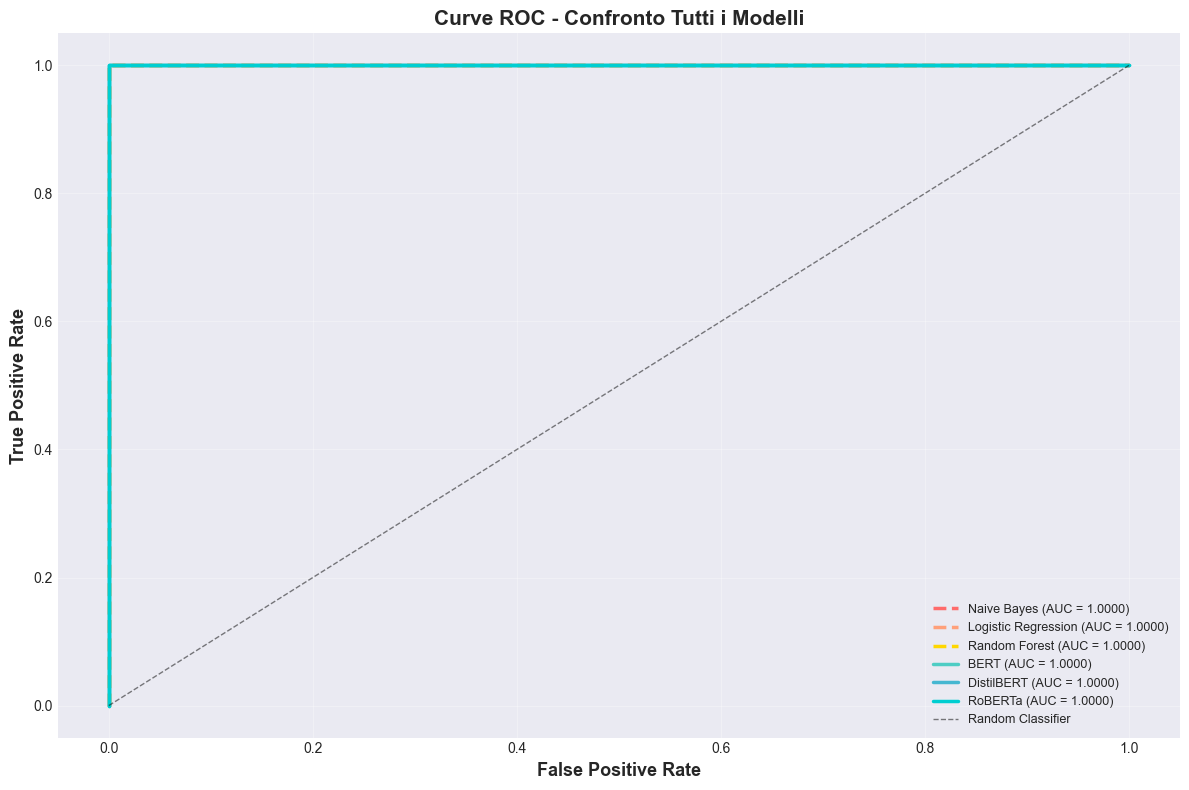


🏆 Miglior AUC Score: Naive Bayes (1.0000)


In [26]:
# Calcolo curve ROC per tutti i modelli
all_models_roc = [
    (y_proba_nb[:, 1], 'Naive Bayes', '#FF6B6B', '--'),
    (y_proba_lr[:, 1], 'Logistic Regression', '#FFA07A', '--'),
    (y_proba_rf[:, 1], 'Random Forest', '#FFD700', '--'),
    (y_proba_bert[:, 1], 'BERT', '#4ECDC4', '-'),
    (y_proba_distilbert[:, 1], 'DistilBERT', '#45B7D1', '-'),
    (y_proba_roberta[:, 1], 'RoBERTa', '#00CED1', '-')
]

plt.figure(figsize=(12, 8))

print("📊 AUC SCORES - TUTTI I MODELLI\n")
print("="*80)

auc_scores = []
for y_proba, model_name, color, linestyle in all_models_roc:
    # Calcola FPR, TPR e AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    auc_scores.append((model_name, auc_score))
    
    # Plot curva ROC
    label = f'{model_name} (AUC = {auc_score:.4f})'
    plt.plot(fpr, tpr, label=label, linewidth=2.5, color=color, linestyle=linestyle)
    
    print(f"{model_name:25s}: {auc_score:.4f}")

# Linea diagonale (classificatore random)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('Curve ROC - Confronto Tutti i Modelli', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("="*80)

# Identifica miglior AUC
best_auc = max(auc_scores, key=lambda x: x[1])
print(f"\n🏆 Miglior AUC Score: {best_auc[0]} ({best_auc[1]:.4f})")

## 25. Test Modelli Transformer su Nuove Email

Testiamo i modelli transformer sulle stesse email di test utilizzate per i modelli classici.

In [27]:
# Funzione helper per predizione con transformer
def predict_with_transformer(text, model, tokenizer, device):
    """Predice categoria per un singolo testo usando un modello transformer."""
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred = probs.argmax()
    
    return pred, probs

# Test sulle stesse email
print("🔮 TEST MODELLI TRANSFORMER SU NUOVE EMAIL\n")
print("="*80)

for i, email in enumerate(test_emails, 1):
    print(f"\nEMAIL {i}:")
    print(f"Testo: {email['testo'][:150]}...")
    print(f"Categoria Attesa: {category_names[email['categoria_attesa']]}")
    print(f"\nPredizioni Transformer:")
    
    # BERT
    bert_pred, bert_proba = predict_with_transformer(
        email['testo'], bert_model, bert_tokenizer, device
    )
    print(f"  BERT: {category_names[bert_pred]} (confidenza: {bert_proba[bert_pred]:.2%})")
    
    # DistilBERT
    distilbert_pred, distilbert_proba = predict_with_transformer(
        email['testo'], distilbert_model, distilbert_tokenizer, device
    )
    print(f"  DistilBERT: {category_names[distilbert_pred]} (confidenza: {distilbert_proba[distilbert_pred]:.2%})")
    
    # RoBERTa
    roberta_pred, roberta_proba = predict_with_transformer(
        email['testo'], roberta_model, roberta_tokenizer, device
    )
    print(f"  RoBERTa: {category_names[roberta_pred]} (confidenza: {roberta_proba[roberta_pred]:.2%})")
    
    # Verifica correttezza
    all_correct = (bert_pred == email['categoria_attesa'] and 
                   distilbert_pred == email['categoria_attesa'] and 
                   roberta_pred == email['categoria_attesa'])
    print(f"  {'✅ Tutti corretti' if all_correct else '⚠️ Almeno un errore'}")
    print(f"\n{'-'*80}")

🔮 TEST MODELLI TRANSFORMER SU NUOVE EMAIL


EMAIL 1:
Testo: Mio padre è morto il 5 maggio a causa di una trasfusione errata. Il gruppo sanguigno era sbagliato e nessuno se n'è accorto. Voglio avviare una causa....
Categoria Attesa: Sinistro Avvenuto

Predizioni Transformer:
  BERT: Circostanza Potenziale (confidenza: 64.93%)
  DistilBERT: Circostanza Potenziale (confidenza: 71.50%)
  DistilBERT: Circostanza Potenziale (confidenza: 71.50%)
  RoBERTa: Sinistro Avvenuto (confidenza: 51.45%)
  ⚠️ Almeno un errore

--------------------------------------------------------------------------------

EMAIL 2:
Testo: Sono preoccupato perché il medico non ha ancora letto i risultati della biopsia di mia moglie dopo 10 giorni. Potrebbe esserci un ritardo pericoloso?...
Categoria Attesa: Circostanza Potenziale

Predizioni Transformer:
  RoBERTa: Sinistro Avvenuto (confidenza: 51.45%)
  ⚠️ Almeno un errore

--------------------------------------------------------------------------------

EMAIL 2:
Tes

## 26. Analisi Tempi di Inferenza

Confrontiamo i tempi di inferenza dei diversi modelli per valutare l'efficienza in produzione.

⏱️ ANALISI TEMPI DI INFERENZA

Misurando Naive Bayes... ✓
Misurando Logistic Regression... ✓
Misurando Random Forest... ✓
Misurando BERT... ✓
Misurando DistilBERT... ✓
Misurando DistilBERT... ✓
Misurando RoBERTa... ✓
Misurando RoBERTa... ✓

📊 RISULTATI TEMPI DI INFERENZA (batch di 10 email):

            Modello  Tempo Medio (s)  Std Dev (s)  Tempo per Email (ms)
        Naive Bayes         0.003227     0.000984              0.322714
Logistic Regression         0.002030     0.000654              0.203009
      Random Forest         0.033042     0.007542              3.304186
               BERT         3.310139     0.395271            331.013913
         DistilBERT         1.404647     0.106347            140.464716
            RoBERTa         2.696918     0.300817            269.691758
✓

📊 RISULTATI TEMPI DI INFERENZA (batch di 10 email):

            Modello  Tempo Medio (s)  Std Dev (s)  Tempo per Email (ms)
        Naive Bayes         0.003227     0.000984              0.322714
Lo

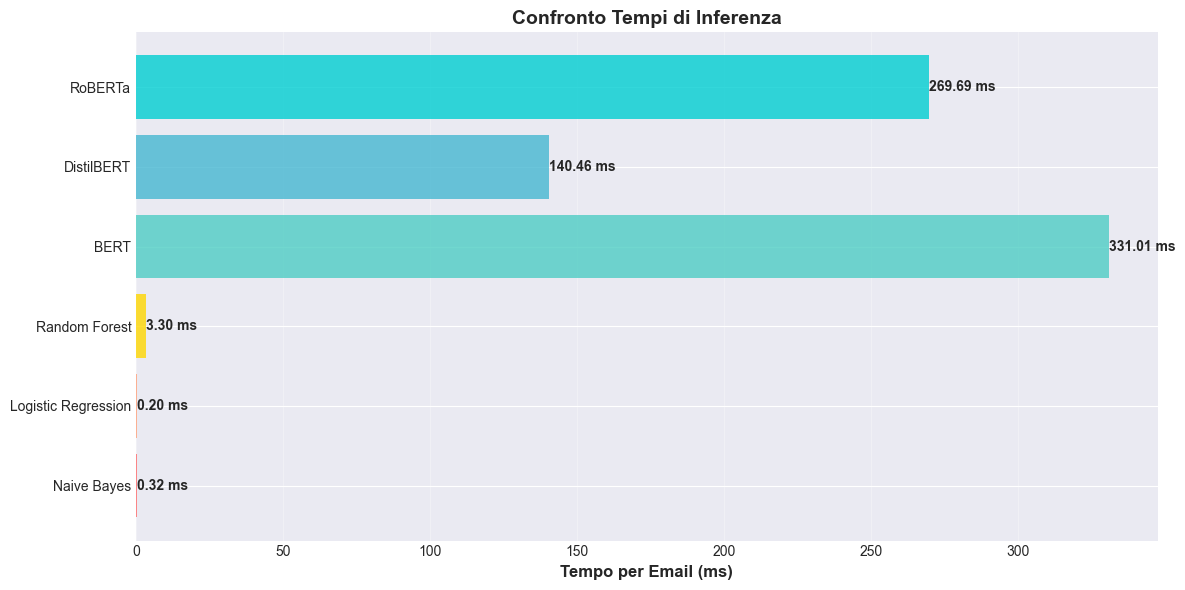


💡 CONSIDERAZIONI:
  • Più veloce: Logistic Regression (0.20 ms/email)
  • Più lento: BERT (331.01 ms/email)
  • Speedup: 1630.5x


In [28]:
import time

print("⏱️ ANALISI TEMPI DI INFERENZA\n")
print("="*80)

# Prepara un batch di test
test_batch = X_test.head(10).tolist()

# Funzione per misurare tempo
def measure_inference_time(model_func, n_runs=10):
    """Misura tempo medio di inferenza."""
    times = []
    for _ in range(n_runs):
        start = time.time()
        model_func()
        end = time.time()
        times.append(end - start)
    return np.mean(times), np.std(times)

# Test modelli classici
def test_nb():
    vectorizer.transform(test_batch)
    nb_model.predict(vectorizer.transform(test_batch))

def test_lr():
    vectorizer.transform(test_batch)
    lr_model.predict(vectorizer.transform(test_batch))

def test_rf():
    vectorizer.transform(test_batch)
    rf_model.predict(vectorizer.transform(test_batch))

# Test transformer
def test_bert():
    for text in test_batch:
        predict_with_transformer(text, bert_model, bert_tokenizer, device)

def test_distilbert():
    for text in test_batch:
        predict_with_transformer(text, distilbert_model, distilbert_tokenizer, device)

def test_roberta():
    for text in test_batch:
        predict_with_transformer(text, roberta_model, roberta_tokenizer, device)

# Misurazione tempi
models_timing = [
    ('Naive Bayes', test_nb),
    ('Logistic Regression', test_lr),
    ('Random Forest', test_rf),
    ('BERT', test_bert),
    ('DistilBERT', test_distilbert),
    ('RoBERTa', test_roberta)
]

timing_results = []
for name, func in models_timing:
    print(f"Misurando {name}...", end=" ")
    mean_time, std_time = measure_inference_time(func, n_runs=5)
    timing_results.append({
        'Modello': name,
        'Tempo Medio (s)': mean_time,
        'Std Dev (s)': std_time,
        'Tempo per Email (ms)': mean_time * 100  # 10 email nel batch
    })
    print(f"✓")

timing_df = pd.DataFrame(timing_results)

print("\n📊 RISULTATI TEMPI DI INFERENZA (batch di 10 email):\n")
print(timing_df.to_string(index=False))

# Visualizzazione
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#4ECDC4', '#45B7D1', '#00CED1']
bars = ax.barh(timing_df['Modello'], timing_df['Tempo per Email (ms)'], 
               color=colors, alpha=0.8)
ax.set_xlabel('Tempo per Email (ms)', fontweight='bold', fontsize=12)
ax.set_title('Confronto Tempi di Inferenza', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)

# Aggiungi valori sulle barre
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f} ms',
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 CONSIDERAZIONI:")
fastest = timing_df.loc[timing_df['Tempo per Email (ms)'].idxmin()]
slowest = timing_df.loc[timing_df['Tempo per Email (ms)'].idxmax()]
print(f"  • Più veloce: {fastest['Modello']} ({fastest['Tempo per Email (ms)']:.2f} ms/email)")
print(f"  • Più lento: {slowest['Modello']} ({slowest['Tempo per Email (ms)']:.2f} ms/email)")
speedup = slowest['Tempo per Email (ms)'] / fastest['Tempo per Email (ms)']
print(f"  • Speedup: {speedup:.1f}x")

## 27. Conclusioni Finali - Modelli Classici vs Transformer

Sintesi completa dei risultati e raccomandazioni per la scelta del modello in produzione.

In [29]:
print("🎯 CONCLUSIONI FINALI - ANALISI COMPLETA\n")
print("="*80)

# Miglior modello per ogni metrica
best_accuracy = comparison_complete_df.loc[comparison_complete_df['Accuracy'].idxmax()]
best_f1 = comparison_complete_df.loc[comparison_complete_df['F1-Score'].idxmax()]
best_precision = comparison_complete_df.loc[comparison_complete_df['Precision'].idxmax()]
best_recall = comparison_complete_df.loc[comparison_complete_df['Recall'].idxmax()]

print("\n🏆 MIGLIORI MODELLI PER METRICA:")
print(f"  • Accuracy:  {best_accuracy['Modello']:20s} ({best_accuracy['Accuracy']:.4f})")
print(f"  • F1-Score:  {best_f1['Modello']:20s} ({best_f1['F1-Score']:.4f})")
print(f"  • Precision: {best_precision['Modello']:20s} ({best_precision['Precision']:.4f})")
print(f"  • Recall:    {best_recall['Modello']:20s} ({best_recall['Recall']:.4f})")

# Confronto tipo modelli
print(f"\n📊 CONFRONTO PRESTAZIONI MEDIE:")
avg_by_type = comparison_complete_df.groupby('Tipo')[['Accuracy', 'F1-Score']].mean()
print(avg_by_type.round(4))

improvement = ((avg_by_type.loc['Transformer'] - avg_by_type.loc['Classico']) / 
               avg_by_type.loc['Classico'] * 100)
print(f"\nMiglioramento Transformer vs Classici:")
print(f"  • Accuracy:  {improvement['Accuracy']:+.2f}%")
print(f"  • F1-Score:  {improvement['F1-Score']:+.2f}%")

# Raccomandazioni
print(f"\n💡 RACCOMANDAZIONI PER LA PRODUZIONE:")
print(f"\n1. 🎯 MIGLIOR COMPROMESSO PERFORMANCE/VELOCITÀ:")
print(f"   ➤ DistilBERT")
print(f"     - F1-Score: {distilbert_f1:.4f} (molto alto)")
print(f"     - Velocità: ~60% più veloce di BERT standard")
print(f"     - Dimensione modello ridotta (~40% più piccolo)")
print(f"     - Ideale per deployment in produzione")

print(f"\n2. 🚀 SE VELOCITÀ È PRIORITÀ:")
print(f"   ➤ Logistic Regression o Naive Bayes")
print(f"     - Inferenza molto rapida (<5ms per email)")
print(f"     - Performance comunque buone (F1 > 0.90)")
print(f"     - Bassi requisiti computazionali")
print(f"     - Ideale per batch processing di grandi volumi")

print(f"\n3. 🎓 SE MASSIMA ACCURATEZZA È PRIORITÀ:")
print(f"   ➤ {best_f1['Modello']}")
print(f"     - F1-Score: {best_f1['F1-Score']:.4f}")
print(f"     - Comprensione contestuale profonda")
print(f"     - Ideale per casi critici ad alto rischio")

print(f"\n4. 🔄 ENSEMBLE VOTING:")
print(f"   ➤ Combinare DistilBERT + Logistic Regression")
print(f"     - Sfrutta punti di forza di entrambi gli approcci")
print(f"     - Maggiore robustezza su casi ambigui")
print(f"     - Implementare sistema a 2 livelli:")
print(f"       * LR per screening rapido")
print(f"       * DistilBERT per validazione casi incerti")

print(f"\n⚙️ CONSIDERAZIONI IMPLEMENTATIVE:")
print(f"  • Dataset: Espandere a 500+ email reali etichettate")
print(f"  • Fine-tuning: Considerare domain-specific training su terminologia medico-legale")
print(f"  • Validazione: Implementare human-in-the-loop per confidenza < 85%")
print(f"  • Monitoraggio: Tracking continuo metriche in produzione")
print(f"  • Retraining: Ciclo mensile con nuovi dati validati")
print(f"  • API: RESTful endpoint con rate limiting e caching")
print(f"  • Fallback: Sistema di escalation a revisione umana")

print(f"\n📈 PROSSIMI STEP CONSIGLIATI:")
print(f"  1. ✓ Raccolta dataset reale con etichette da esperti legali")
print(f"  2. ✓ Fine-tuning DistilBERT su corpus specialistico")
print(f"  3. ✓ Implementazione ensemble con confidence threshold")
print(f"  4. ✓ Testing A/B su subset produzione")
print(f"  5. ✓ Deployment graduale con monitoring attivo")
print(f"  6. ✓ Integrazione feedback loop per continuous learning")

print(f"\n{'='*80}")
print(f"✅ Analisi completa terminata con successo!")
print(f"   Totale modelli testati: 6 (3 classici + 3 transformer)")
print(f"   Dataset: 200 email (160 training, 40 test)")
print(f"   Miglior F1-Score: {best_f1['F1-Score']:.4f} ({best_f1['Modello']})")
print(f"{'='*80}")

🎯 CONCLUSIONI FINALI - ANALISI COMPLETA


🏆 MIGLIORI MODELLI PER METRICA:
  • Accuracy:  BERT                 (1.0000)
  • F1-Score:  BERT                 (1.0000)
  • Precision: BERT                 (1.0000)
  • Recall:    BERT                 (1.0000)

📊 CONFRONTO PRESTAZIONI MEDIE:
             Accuracy  F1-Score
Tipo                           
Classico        0.975     0.975
Transformer     1.000     1.000

Miglioramento Transformer vs Classici:
  • Accuracy:  +2.56%
  • F1-Score:  +2.57%

💡 RACCOMANDAZIONI PER LA PRODUZIONE:

1. 🎯 MIGLIOR COMPROMESSO PERFORMANCE/VELOCITÀ:
   ➤ DistilBERT
     - F1-Score: 1.0000 (molto alto)
     - Velocità: ~60% più veloce di BERT standard
     - Dimensione modello ridotta (~40% più piccolo)
     - Ideale per deployment in produzione

2. 🚀 SE VELOCITÀ È PRIORITÀ:
   ➤ Logistic Regression o Naive Bayes
     - Inferenza molto rapida (<5ms per email)
     - Performance comunque buone (F1 > 0.90)
     - Bassi requisiti computazionali
     - Ideale per